# 0.Load Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms.autoaugment import AutoAugmentPolicy
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import _LRScheduler, CosineAnnealingLR

from PIL import Image
import math
import matplotlib.pyplot as plt
import numpy as np
import time

import requests
import zipfile
import os

from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
img_size = 112
patch_size = 8
num_classes = 200
dropout = 0.1

# 1.Modeling

## 1)Patch Embedding

In [3]:
class PatchEmbedding(nn.Module):
    """
    이미지를 패치로 분할하고, 각 패치를 임베딩하는 클래스입니다.

    Attributes:
    patch_size (int): 패치의 크기 (예: 16x16).
    n_patches (int): 이미지당 생성되는 패치의 총 수.
    projection (nn.Conv2d): 패치를 임베딩 벡터로 변환하는 컨볼루션 레이어.

    Args:
    img_size (int): 입력 이미지의 크기 (예: 32x32).
    patch_size (int): 패치의 크기 (예: 16x16).
    in_channels (int): 입력 이미지의 채널 수 (RGB의 경우 3).
    embed_dim (int): 임베딩 차원의 크기.
    """
    def __init__(self, img_size:int=32, patch_size:int=2, in_channels:int=3, embed_dim:int=768):
        super().__init__()
        
        # Patch 정보 인식
        self.patch_size = patch_size
        assert img_size % patch_size == 0, f'img size({img_size})는 patch size({patch_size})로 나뉘어야 합니다.'
        self.n_patches = (img_size // patch_size) ** 2

        # 컨볼루션을 사용하여 패치를 임베딩 벡터로 변환
        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        
        # class token 추가
        self.cls_token = nn.Parameter(torch.zeros(1,1,embed_dim))        

    def forward(self, x):
        # x: [배치 크기, 채널 수, 높이, 너비]
        x = self.projection(x)  # 컨볼루션을 통한 임베딩: [배치 크기, 임베딩 차원, 패치 수, _]
        x = x.flatten(2)        # 평탄화: [배치 크기, 임베딩 차원, 패치 수]
        x = x.transpose(1, 2)   # 변환: [배치 크기, 패치 수, 임베딩 차원]
        
        cls_tokens = self.cls_token.expand(x.size(0), -1, -1) # [배치크기, 1, 임베딩 차원]
        x = torch.cat((cls_tokens, x), dim=1) # cls_token 추가: [배치크기, 패치 수+1, 임베딩 차원]
        return x

## 2)Positional Embedding

In [4]:
class PositionalEmbedding(nn.Module):
    """
    위치 임베딩을 추가하는 클래스입니다. 각 패치에 대한 위치 정보를 제공합니다.

    Attributes:
    scale (torch.Tensor): 스케일링 펙터.
    position_embedding (torch.nn.Parameter): 학습 가능한 위치 인코딩.

    Args:
    num_patches (int): 이미지당 생성되는 패치의 수.
    embed_dim (int): 임베딩 차원의 크기.
    """
    def __init__(self, num_patches:int, embed_dim:int):
        super().__init__()
        self.scale = torch.sqrt(torch.tensor(embed_dim, dtype=torch.float32))
        self.position_embedding = nn.Parameter(torch.zeros(1, num_patches+1, embed_dim)) # [1, 패치 수+1, 임베딩 차원]

    def forward(self, x):
        x = self.scale*x + self.position_embedding # scaled x에 위치 정보를 임베딩에 더함 
        # x += self.position_embedding  
        return x # [배치 크기, 패치 수+1, 임베딩 차원]

## 3)MHA

In [5]:
# 파라미터 수 비교를 위해 가져온 이전 구현체
class MHA(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()

        self.d_model = d_model
        self.n_heads = n_heads
        assert d_model % n_heads == 0, f'd_model ({d_model})은 n_heads ({n_heads})로 나누어 떨어져야 합니다.'

        self.head_dim = d_model // n_heads  # int 형변환 제거

        # 쿼리, 키, 값에 대한 선형 변환
        self.fc_q = nn.Linear(d_model, d_model) 
        self.fc_k = nn.Linear(d_model, d_model) 
        self.fc_v = nn.Linear(d_model, d_model)
        self.fc_o = nn.Linear(d_model, d_model)

        # 어텐션 점수를 위한 스케일 요소
        self.scale = torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))
        

    def forward(self, Q, K, V):
        batch_size = Q.shape[0]

        # 쿼리, 키, 값에 대한 선형 변환 수행
        Q = self.fc_q(Q) 
        K = self.fc_k(K)
        V = self.fc_v(V)

        # 멀티 헤드 어텐션을 위해 텐서 재구성 및 순서 변경
        Q = Q.reshape(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.reshape(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.reshape(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        # 스케일드 닷-프로덕트 어텐션 계산
        attention_score = Q @ K.permute(0, 1, 3, 2) / self.scale

        # 소프트맥스를 사용하여 어텐션 확률 계산
        attention_dist = torch.softmax(attention_score, dim=-1)

        # 어텐션 결과
        attention = attention_dist @ V

        # 어텐션 헤드 재조립
        x = attention.permute(0, 2, 1, 3).reshape(batch_size, -1, self.d_model)

        # 최종 선형 변환
        x = self.fc_o(x)

        return x

## 4)Transformer Encoder Layer

In [6]:
class TransformerEncoderLayer(nn.Module):
    """
    Transformer Encoder 레이어를 정의하는 클래스입니다.

    Attributes:
    norm1, norm2 (nn.LayerNorm): 정규화 레이어.
    attn (nn.MultiheadAttention): 멀티헤드 어텐션 레이어.
    mlp (nn.Sequential): 피드포워드 네트워크.

    Args:
    embed_dim (int): 임베딩 차원의 크기.
    num_heads (int): 멀티헤드 어텐션에서의 헤드 수.
    mlp_ratio (float): 첫 번째 선형 레이어의 출력 차원을 결정하는 비율.
    dropout (float): 드롭아웃 비율.
    """
    def __init__(self, embed_dim:int, num_heads:int, mlp_ratio:float=4.0, dropout:float=0.1, estimate_params:bool=False):
        super().__init__()
        self.norm = nn.LayerNorm(embed_dim)
        self.estimate_params = estimate_params
        if estimate_params:
            self.attn = MHA(embed_dim, num_heads)
        else :
            self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout) # [attention_output, attention weights]        

        mlp_hidden_dim = int(mlp_ratio * embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        # 멀티헤드 어텐션과 피드포워드 네트워크를 적용
        if self.estimate_params:
            x = self.norm(x)
            x = x + self.attn(x, x, x)
        else :
            x = x + self.attn(x, x, x)[0] # attention output만 사용
        
        x2 = self.norm(x)
        x = x + self.mlp(x2)
        return x

## 5)Vision Transformer(ViT)

In [7]:
class VisionTransformer(nn.Module):
    """
    전체 Vision Transformer 모델을 정의하는 클래스입니다.

    Attributes:
    patch_embed (PatchEmbedding): 이미지를 패치로 분할하고 임베딩하는 레이어.
    pos_embed (PositionalEncoding): 위치 인코딩 레이어.
    transformer_encoders (nn.ModuleList): Transformer Encoder 레이어들의 리스트.
    norm (nn.LayerNorm): 정규화 레이어.
    head (nn.Linear): 최종 분류를 위한 선형 레이어.

    Args:
    img_size (int): 입력 이미지의 크기 (예: 32x32).
    patch_size (int): 패치의 크기 (예: 16x16).
    in_channels (int): 입력 이미지의 채널 수 (RGB의 경우 3).
    num_classes (int): 분류할 클래스의 수 (CIFAR-10의 경우 10).
    embed_dim (int): 임베딩 차원의 크기.
    num_heads (int): 멀티헤드 어텐션에서의 헤드 수.
    num_layers (int): Transformer Encoder 레이어의 수.
    mlp_ratio (float): 피드포워드 네트워크의 차원 확장 비율.
    dropout (float): 드롭아웃 비율.
    """
    def __init__(self, img_size:int=32, patch_size:int=4, in_channels:int=3, 
                 num_classes:int=100, embed_dim:int=768, num_heads:int=12, 
                 num_layers:int=12, mlp_ratio:float=4., dropout:float=0.1,
                 estimate_params:bool=False):
        super().__init__()

        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embed.n_patches
        self.pos_embed = PositionalEmbedding(num_patches, embed_dim)

        self.transformer_encoders = nn.ModuleList([
            TransformerEncoderLayer(embed_dim, num_heads, mlp_ratio, dropout,estimate_params) 
            for _ in range(num_layers)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        self.dropout = nn.Dropout(dropout)
        
        # 파라미터 초기화
        for m in self.modules():
            if hasattr(m, 'weight') and m.weight.dim() > 1: 
                nn.init.xavier_uniform_(m.weight) 

    def forward(self, x):
        x = self.patch_embed(x)  # 이미지를 패치로 분할하고 임베딩
        x = self.pos_embed(x)    # 위치 인코딩 적용
        x = self.dropout(x)      # 임베딩 작업 후 dropout

        for layer in self.transformer_encoders:
            x = layer(x)  # 각 Transformer Encoder 레이어 적용

        x = self.norm(x)        # 정규화
        x = self.dropout(x)     # dropout 적용
        
        # cls_token의 출력을 사용하여 분류
        cls_token_output = x[:, 0]  # 첫 번째 토큰 (cls_token) 추출
        x = self.head(cls_token_output)  # 최종 분류를 위한 선형 레이어
        return x

## 6)Model Test

In [8]:
# 모델 테스트 - 임의의 이미지 데이터 생성 (B, C, W, H)
test_img = torch.randn(2, 3, img_size, img_size) 

# 모델 초기화
vit = VisionTransformer(img_size=img_size, 
                        patch_size=patch_size, 
                        num_classes=num_classes, 
                        dropout=dropout,
                        estimate_params=True) # 파라미터 수를 측정하고 싶으면 True
output = vit(test_img)     # 테스트 이미지를 모델에 통과

output.shape  # 결과의 형태 확인 ([배치 크기, 클래스 수])

torch.Size([2, 200])

## 7)Model Summary

In [9]:
from torchsummary import summary

# torch summary는 무조건 cuda:0에서만 가능
summary(vit.to('cuda'), (3,img_size,img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         148,224
    PatchEmbedding-2             [-1, 197, 768]               0
PositionalEmbedding-3             [-1, 197, 768]               0
           Dropout-4             [-1, 197, 768]               0
         LayerNorm-5             [-1, 197, 768]           1,536
            Linear-6             [-1, 197, 768]         590,592
            Linear-7             [-1, 197, 768]         590,592
            Linear-8             [-1, 197, 768]         590,592
            Linear-9             [-1, 197, 768]         590,592
              MHA-10             [-1, 197, 768]               0
        LayerNorm-11             [-1, 197, 768]           1,536
           Linear-12            [-1, 197, 3072]       2,362,368
             GELU-13            [-1, 197, 3072]               0
          Dropout-14            [-1, 1

# 2.Prework of Training

## 1)Set Hyperparameters

In [10]:
batch_size = 512
num_workers = 16

label_smoothing = 0.1
learning_rate = 0.003
epochs = 10

device = 'cuda:3'
model_path = 'tiny_imageNet.pth'  # 모델 저장 경로

## 2)Load Data & Construct Dataset

In [12]:
# Tiny ImageNet 데이터셋 다운로드 URL
url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
filename = url.split('/')[-1]  # 파일명 추출
folder_name = './data/tiny-imagenet-200'

if not os.path.isdir(folder_name):
    # 데이터셋을 다운로드합니다.
    r = requests.get(url, stream=True)
    with open(filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192): 
            if chunk:  # 필터링된 청크 데이터를 파일에 씁니다.
                f.write(chunk)
    
    # 다운로드한 zip 파일을 추출합니다.
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('.')  # 현재 디렉토리에 압축 해제
    os.remove(filename)  # zip 파일 삭제

# 이제 'tiny-imagenet-200' 폴더 안에 데이터셋이 준비되어 있습니다.


In [ ]:
# # 데이터 증강을 위한 전처리
# transform_train = transforms.Compose([
#     transforms.RandomResizedCrop(224),
#     transforms.RandomHorizontalFlip(),  # 50% 확률로 수평 뒤집기
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 색상 변경
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# transform_test = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


In [13]:
# 데이터셋 경로 설정
data_dir = './data/tiny-imagenet-200'  # Tiny ImageNet 데이터셋이 저장된 경로
# WordNet ID와 클래스 이름을 매핑하는 사전을 생성합니다.
id_to_class = {}
with open(os.path.join(data_dir, 'wnids.txt'), 'r') as f:
    for idx, line in enumerate(f):
        wordnet_id = line.strip()
        id_to_class[idx] = wordnet_id
        
id_to_class

{0: 'n02124075',
 1: 'n04067472',
 2: 'n04540053',
 3: 'n04099969',
 4: 'n07749582',
 5: 'n01641577',
 6: 'n02802426',
 7: 'n09246464',
 8: 'n07920052',
 9: 'n03970156',
 10: 'n03891332',
 11: 'n02106662',
 12: 'n03201208',
 13: 'n02279972',
 14: 'n02132136',
 15: 'n04146614',
 16: 'n07873807',
 17: 'n02364673',
 18: 'n04507155',
 19: 'n03854065',
 20: 'n03838899',
 21: 'n03733131',
 22: 'n01443537',
 23: 'n07875152',
 24: 'n03544143',
 25: 'n09428293',
 26: 'n03085013',
 27: 'n02437312',
 28: 'n07614500',
 29: 'n03804744',
 30: 'n04265275',
 31: 'n02963159',
 32: 'n02486410',
 33: 'n01944390',
 34: 'n09256479',
 35: 'n02058221',
 36: 'n04275548',
 37: 'n02321529',
 38: 'n02769748',
 39: 'n02099712',
 40: 'n07695742',
 41: 'n02056570',
 42: 'n02281406',
 43: 'n01774750',
 44: 'n02509815',
 45: 'n03983396',
 46: 'n07753592',
 47: 'n04254777',
 48: 'n02233338',
 49: 'n04008634',
 50: 'n02823428',
 51: 'n02236044',
 52: 'n03393912',
 53: 'n07583066',
 54: 'n04074963',
 55: 'n01629819',
 5

In [14]:
# Transforms 정의하기
train_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.AutoAugment(AutoAugmentPolicy.IMAGENET),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [15]:
# 클래스 이름 목록을 만듭니다.
class_names = list(id_to_class.values())

# 클래스 이름을 정수 인덱스로 매핑하는 사전 생성
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

In [16]:
# 사용자 정의 데이터셋 클래스
class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, transform=None, is_train=True):
        """
        Args:
            root_dir (string): 데이터셋의 디렉토리 경로.
            transform (callable, optional): 적용할 transform.
            is_train (bool, optional): 학습 데이터셋인지 테스트 데이터셋인지 구분.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.is_train = is_train
        self.images = []  # 이미지 파일 경로를 저장할 리스트
        self.labels = []  # 레이블을 저장할 리스트

        # 이미지와 레이블을 로드하는 로직
        if is_train:
            for class_dir in os.listdir(os.path.join(root_dir, 'train')):
                class_dir_path = os.path.join(root_dir, 'train', class_dir, 'images')
                for img_file in os.listdir(class_dir_path):
                    self.images.append(os.path.join(class_dir_path, img_file))
                    self.labels.append(class_dir)
        else:
            with open(os.path.join(root_dir, 'val', 'val_annotations.txt'), 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    img_file, wordnet_id = parts[0], parts[1]
                    self.images.append(os.path.join(root_dir, 'val', 'images', img_file))
                    class_name = id_to_class.get(wordnet_id, "")
                    self.labels.append(class_name)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        class_name = self.labels[idx]
        if class_name in class_to_idx:
            label_idx = class_to_idx[class_name]  # 클래스 이름을 정수 인덱스로 변환
        else:
            print(f"Class name '{class_name}' not found in class_to_idx")
            label_idx = -1
        return image, label_idx

In [17]:
# 데이터셋 인스턴스 생성
trainset = TinyImageNetDataset(data_dir, transform=train_transform, is_train=True)
testset = TinyImageNetDataset(data_dir, transform=test_transform, is_train=False)

# DataLoader 설정
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [18]:
# 첫번째 배치를 가져와서 확인합니다.
images, labels = next(iter(trainloader))
print(images.size())  # 결과: torch.Size([512, 3, 224, 224])
print(labels[0])      # 첫 번째 레이블 출력

torch.Size([512, 3, 112, 112])
tensor(12)


## 3)Scheduler

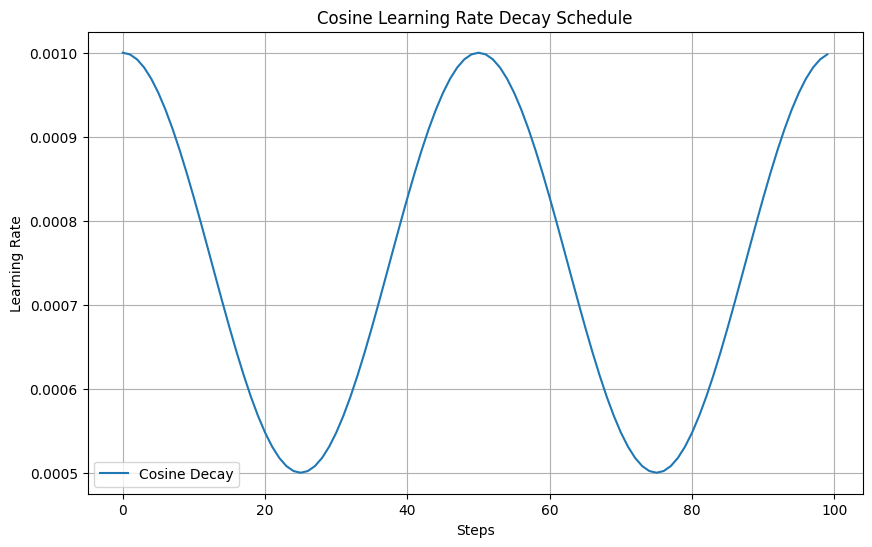

In [26]:
# 모델 및 옵티마이저 설정
model = torch.nn.Linear(10, 2)  # 예시 모델
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 총 스텝 수
total_steps = 100

# 코사인 학습률 감소 스케줄러 설정
scheduler_cosine = CosineAnnealingLR(optimizer, T_max=total_steps//4, eta_min=0.0005)

# 학습률 감소 추적을 위한 리스트
lrs_cosine = []

# 코사인 스케줄러에 대해 학습률 기록
for step in range(total_steps):
    optimizer.step()
    lrs_cosine.append(scheduler_cosine.get_last_lr()[0])
    scheduler_cosine.step()

# 그래프 그리기
steps = np.arange(total_steps)
plt.figure(figsize=(10, 6))
plt.plot(steps, lrs_cosine, label='Cosine Decay')
plt.xlabel('Steps')
plt.ylabel('Learning Rate')
plt.title('Cosine Learning Rate Decay Schedule')
plt.legend()
plt.grid(True)
plt.show()


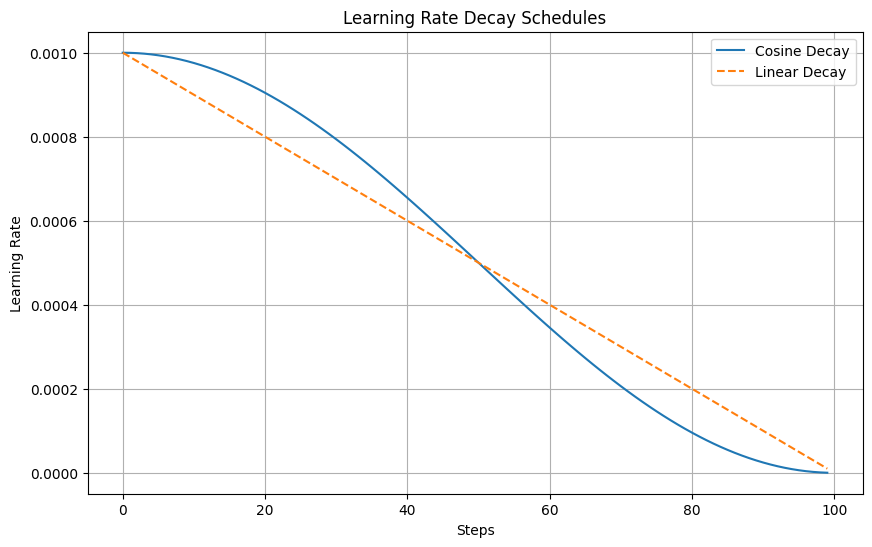

In [27]:
# 모델 및 옵티마이저 설정
model = torch.nn.Linear(10, 2)  # 예시 모델
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 총 스텝 수
total_steps = 100

# 코사인 학습률 감소 스케줄러 설정 (주기를 전체 스텝 수로 변경)
scheduler_cosine = CosineAnnealingLR(optimizer, T_max=total_steps)

# 코사인 및 선형 학습률 감소 추적을 위한 리스트
lrs_cosine = []
lrs_linear = []

# 초기 학습률
initial_lr = 0.001

# 선형 감소 함수 정의
def linear_decay(step, total_steps, initial_lr):
    return initial_lr * (1 - step / total_steps)

# 스케줄러에 대해 학습률 기록
for step in range(total_steps):
    optimizer.step()
    lrs_cosine.append(scheduler_cosine.get_last_lr()[0])
    scheduler_cosine.step()

    linear_lr = linear_decay(step, total_steps, initial_lr)
    lrs_linear.append(linear_lr)

# 그래프 그리기
steps = np.arange(total_steps)
plt.figure(figsize=(10, 6))
plt.plot(steps, lrs_cosine, label='Cosine Decay')
plt.plot(steps, lrs_linear, label='Linear Decay', linestyle='--')
plt.xlabel('Steps')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Decay Schedules')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
class WarmupCosineAnnealingLR(_LRScheduler):
    def __init__(self, optimizer, warmup_steps, total_steps, last_epoch=-1):
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        super(WarmupCosineAnnealingLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.warmup_steps: # during warmup
            return [base_lr * self.last_epoch / self.warmup_steps for base_lr in self.base_lrs]
        else: # post warmup
            current_gap = self.last_epoch - self.warmup_steps
            total_gap = self.total_steps - self.warmup_steps
            cosine_decay = 0.5 * (1 + math.cos(math.pi * current_gap / total_gap))
            return [base_lr * cosine_decay for base_lr in self.base_lrs]

In [ ]:
# 모델 및 옵티마이저 설정
model = torch.nn.Linear(10, 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# 스케줄러 초기화
total_steps = 100
warmup_steps = 10  # 예시로 10 스텝의 warmup 설정
scheduler = WarmupCosineAnnealingLR(optimizer, warmup_steps, total_steps)

# 학습률 기록 및 업데이트
lrs = []
for epoch in range(total_steps):
    optimizer.step()
    lrs.append(scheduler.get_last_lr())
    scheduler.step()

steps = np.arange(total_steps)
plt.figure(figsize=(10, 6))
plt.plot(steps, lrs, label='Warmup with Cosine Decay')
plt.xlabel('Steps')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule: Warmup with Cosine Decay')
plt.legend()
plt.grid(True)
plt.show()

## 4) Optimizer & Loss

In [ ]:
total_steps = len(trainloader) * epochs
warmup_steps = total_steps * 0.1

criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
optimizer = optim.Adam(vit.parameters(), lr=learning_rate, betas=[0.9,0.999], weight_decay=0.3)
scheduler = WarmupCosineAnnealingLR(optimizer, warmup_steps, total_steps)

## 5)EarlyStopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# 3.Train

In [ ]:
from tqdm import tqdm

training_time = 0
early_stopping = EarlyStopping(patience=10)
losses = []
lrs = []
best_loss = float('inf')

vit_save = False
vit.to(device)

for epoch in range(epochs):
    vit.train()
    start_time = time.time()
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader), total=len(trainloader), desc=f"Epoch {epoch + 1}")
    for i, data in pbar:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = vit(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()
        lr = optimizer.param_groups[0]["lr"]
        lrs.append(lr)
    epoch_loss = running_loss / len(trainloader)
    losses.append(epoch_loss)
    
    # 모델 저장
    if epoch_loss < best_loss:
        best_loss = loss
        vit_save = True
        torch.save(vit.state_dict(), model_path)

    epoch_duration = time.time() - start_time
    training_time += epoch_duration
    if vit_save:
        print(f'\tLoss: {epoch_loss}, LR: {lr}, Duration: {epoch_duration:.2f} sec - model saved!')
        vit_save = False
    else :
        print(f'\tLoss: {epoch_loss}, LR: {lr}, Duration: {epoch_duration:.2f} sec')

    # Early Stopping 체크
    early_stopping(loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break
    
torch.save(vit.state_dict(), './last_tiny_imagenet.pth')

# 학습 및 검증 손실 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lrs, label='Learning Rate')
plt.title('Learning Rate')
plt.xlabel('Batch number')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()

In [ ]:
# 예측 수행 및 레이블 저장
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        outputs = vit(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 혼동 행렬 생성
cm = confusion_matrix(all_labels, all_preds)

# 혼동 행렬 시각화
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# 예측과 실제 레이블
y_true = all_labels  # 실제 레이블
y_pred = all_preds  # 모델에 의해 예측된 레이블

# 전체 데이터셋에 대한 정확도
accuracy = accuracy_score(y_true, y_pred)

# 평균 정밀도, 리콜, F1-Score ('weighted')
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

# 판다스 데이터프레임으로 결과 정리
performance_metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [accuracy, precision, recall, f1_score]
})

# 데이터프레임 출력
display(performance_metrics)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Hook 함수 정의 및 등록
attention_maps = []
def get_attention_map(module, input, output):
    global attention_maps
    attention_maps.append(output[1].detach())
hook = vit.transformer_encoders[0].attn.register_forward_hook(get_attention_map)

# 모델을 통한 예측 및 Attention Map 추출
original_images, labels = next(iter(testloader))
outputs = vit(original_images.to(device))
_, predicted = torch.max(outputs, 1)
hook.remove()

# CIFAR-10 클래스 레이블
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Attention Map 가공 및 시각화 개선 함수
def show_attention_on_image(img, attention_map, label, pred, threshold=0.0):
    # 이미지 크기에 맞게 Attention Map 조정
    attention_map = attention_map.cpu().numpy()
    attention_map = attention_map - np.min(attention_map)
    attention_map = attention_map / np.max(attention_map)

    # 임계값 이하의 Attention 값 제거
    # attention_map[attention_map < threshold] = 0

    # 원본 이미지 크기로 Attention Map 업샘플링
    attention_map_resized = np.resize(attention_map, (img.shape[1], img.shape[2]))

    # 원본 이미지와 Attention Map 겹쳐서 표시
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img.permute(1, 2, 0))
    axs[0].axis('off')
    axs[0].set_title(f'Original Image\nTrue Label: {label}')

    axs[1].imshow(img.permute(1, 2, 0))
    axs[1].imshow(attention_map_resized, cmap='jet', alpha=0.6)  # 투명도 조절
    axs[1].axis('off')
    axs[1].set_title(f'Image with Attention Map\nPredicted: {pred}')

    plt.show()

# 각 이미지에 대해 시각화 수행
for i in range(4):
    show_attention_on_image(original_images[i], attention_maps[0][i], classes[labels[i]], classes[predicted[i]])
